In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [3]:
# Load the dataset
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

In [4]:
# Display basic information about the dataset
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# Check the shape of the dataset
print("Dataset shape:", df.shape)

# Display summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Display data types of each column
print(df.dtypes)

Dataset shape: (1460, 81)
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   1

In [6]:
# Handle missing values
# For numeric columns, we'll impute with median
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

# For categorical columns, we'll impute with mode
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].fillna(df[categorical_features].mode().iloc[0])

# Check for duplicate rows
print("Number of duplicate rows:", df.duplicated().sum())

# Remove duplicate rows if any
df = df.drop_duplicates()

# Reset index after removing duplicates
df = df.reset_index(drop=True)

Number of duplicate rows: 0


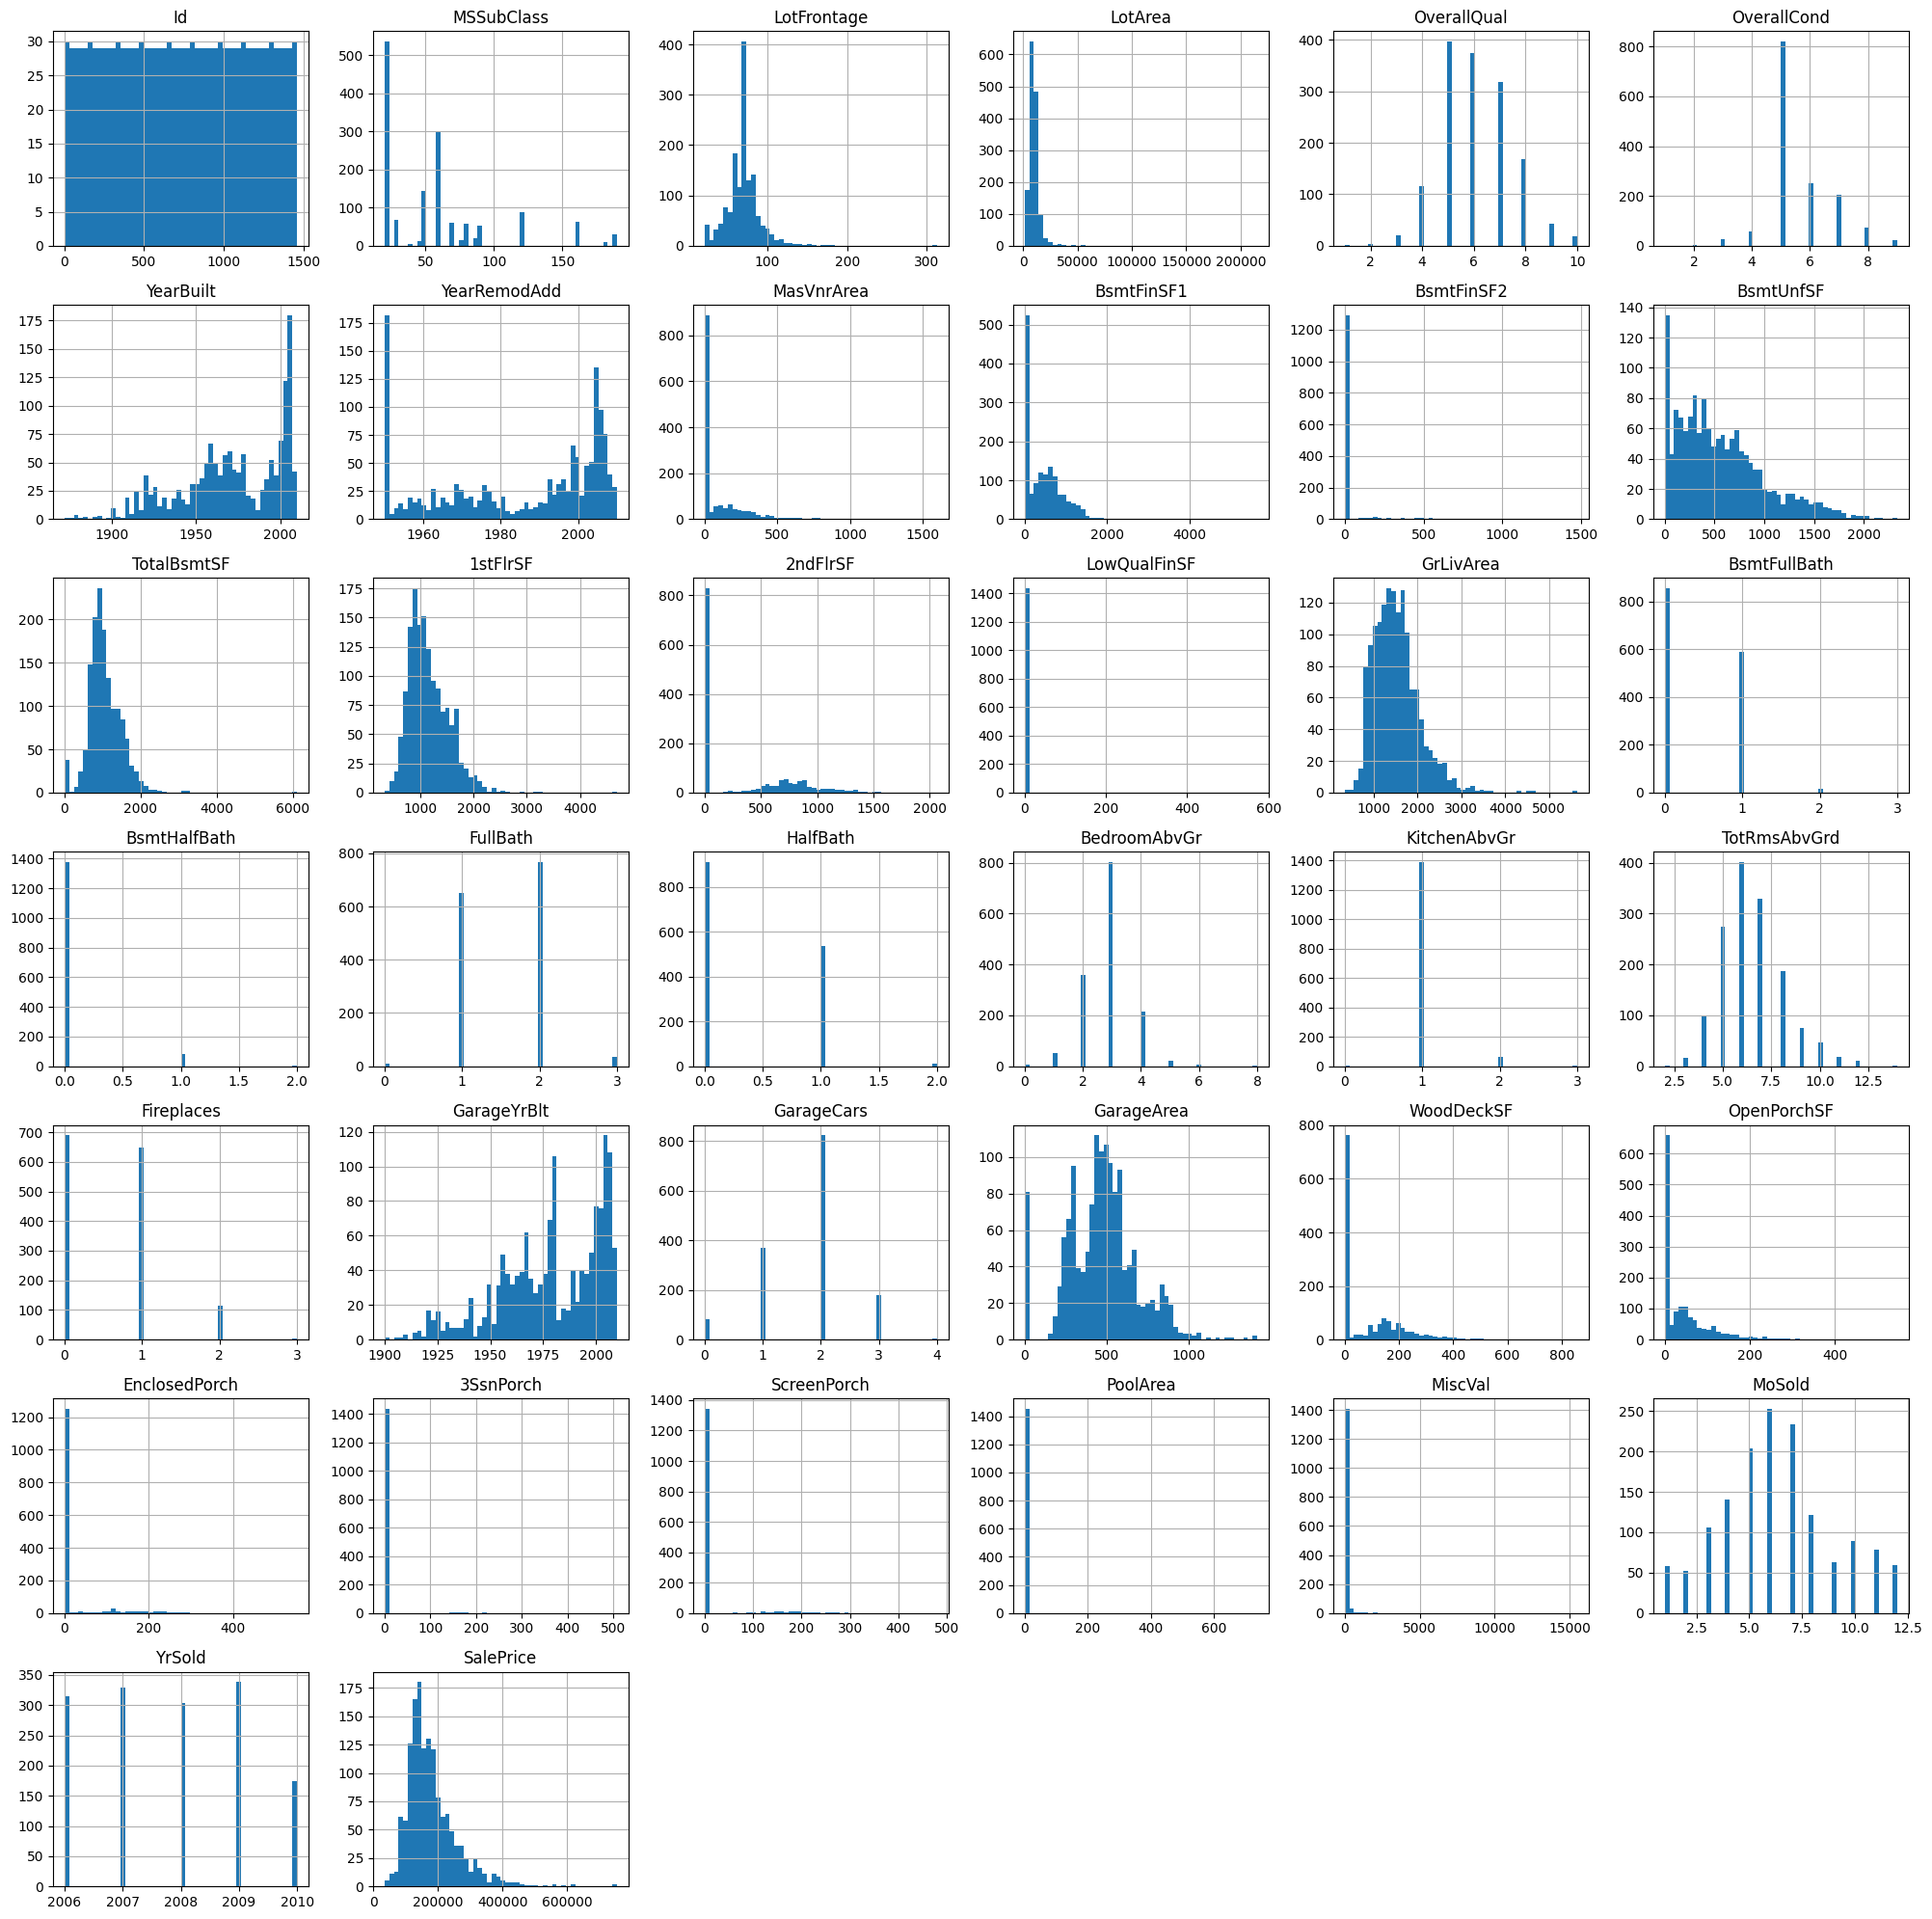

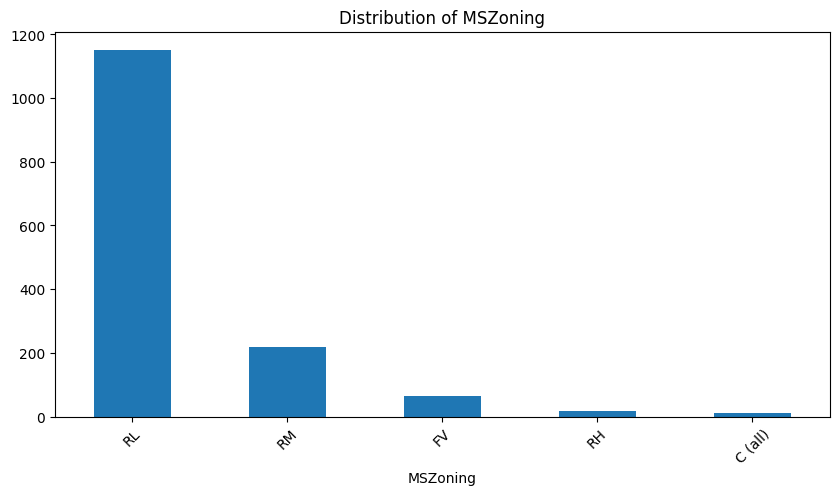

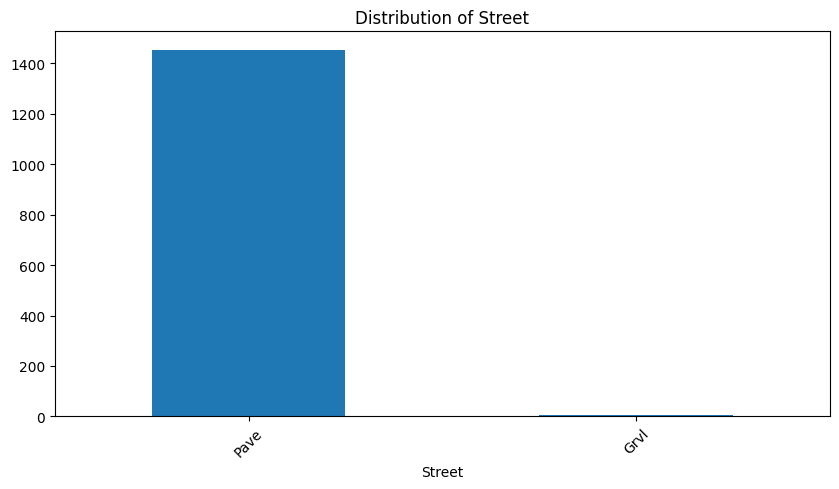

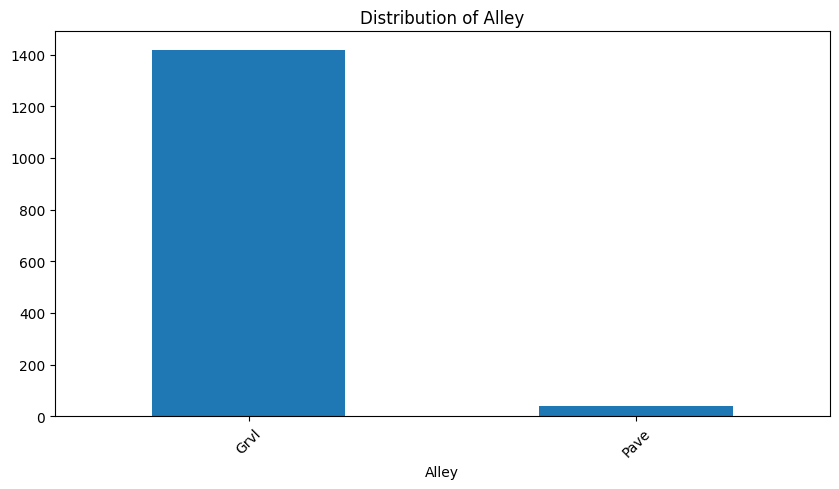

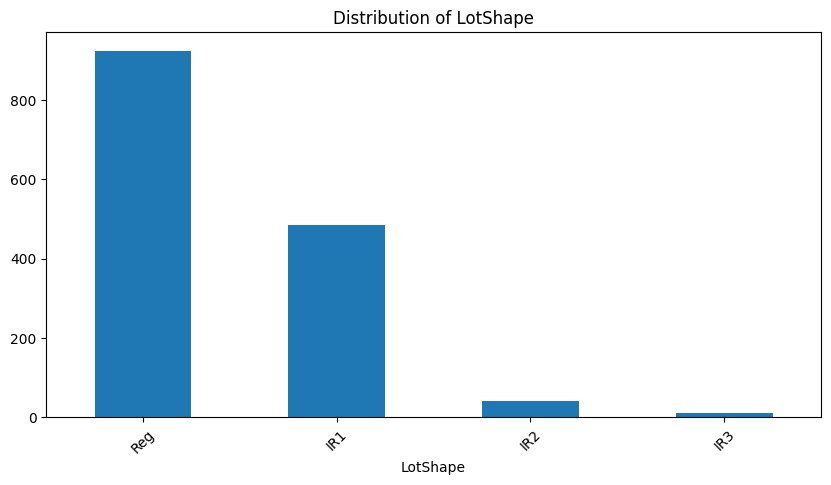

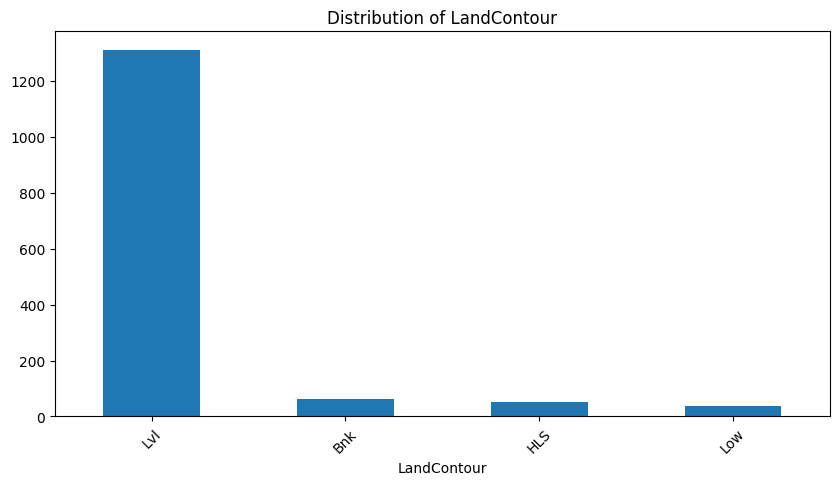

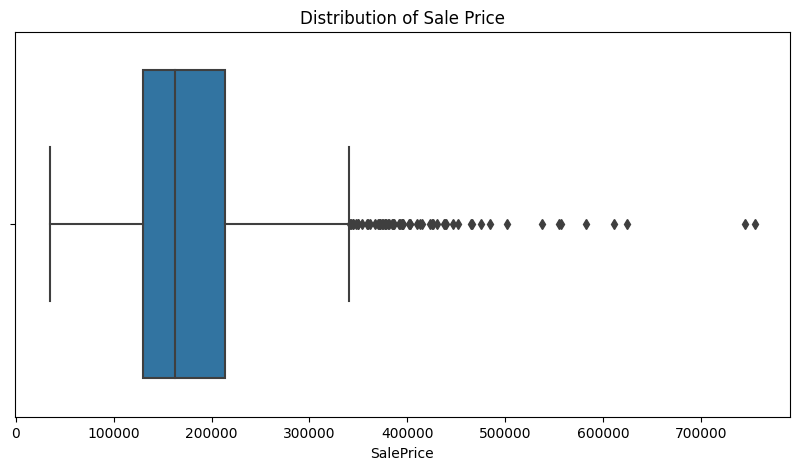

In [7]:
# Histogram for numeric features
df[numeric_features].hist(figsize=(20, 20), bins=50)
plt.tight_layout()
plt.show()

# Bar plots for categorical features
for cat_feature in categorical_features[:5]:  # Limit to first 5 for brevity
    plt.figure(figsize=(10, 5))
    df[cat_feature].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {cat_feature}')
    plt.xticks(rotation=45)
    plt.show()

# Box plot for the target variable (assuming 'SalePrice' is the target)
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['SalePrice'])
plt.title('Distribution of Sale Price')
plt.show()

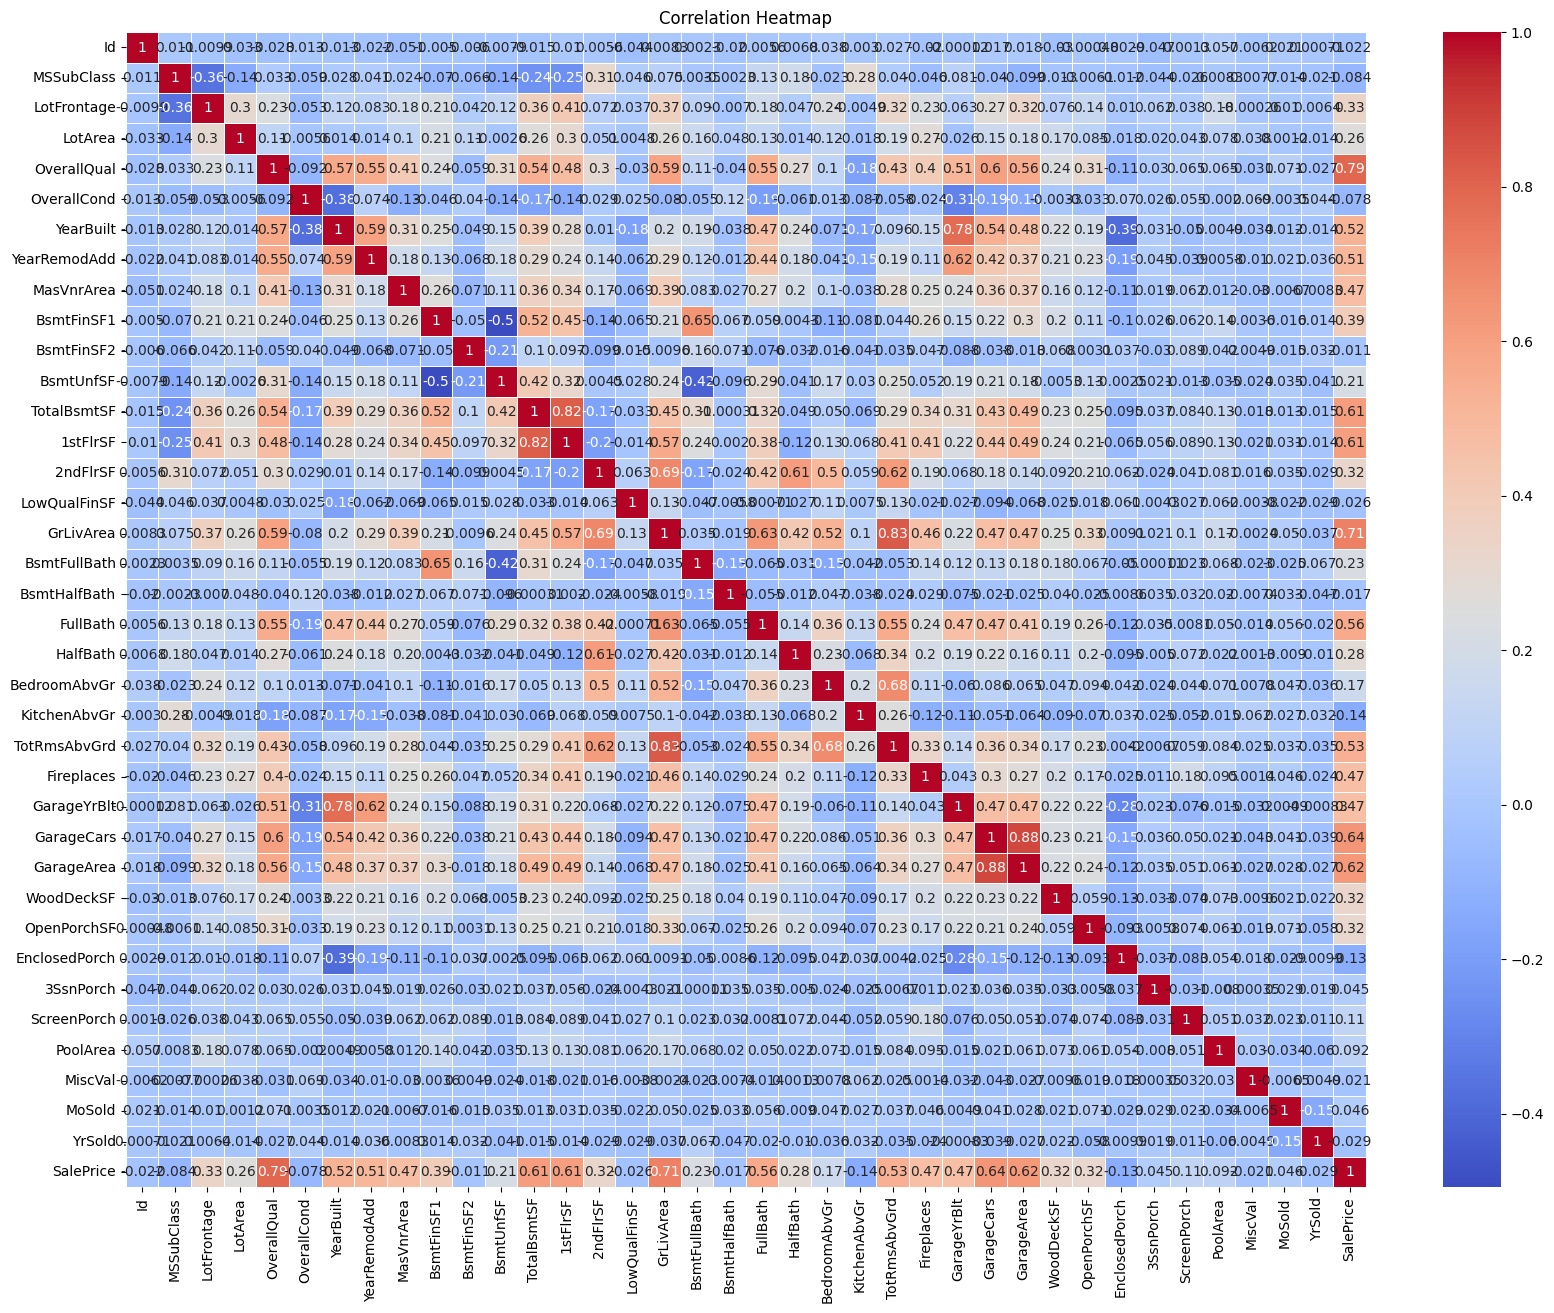

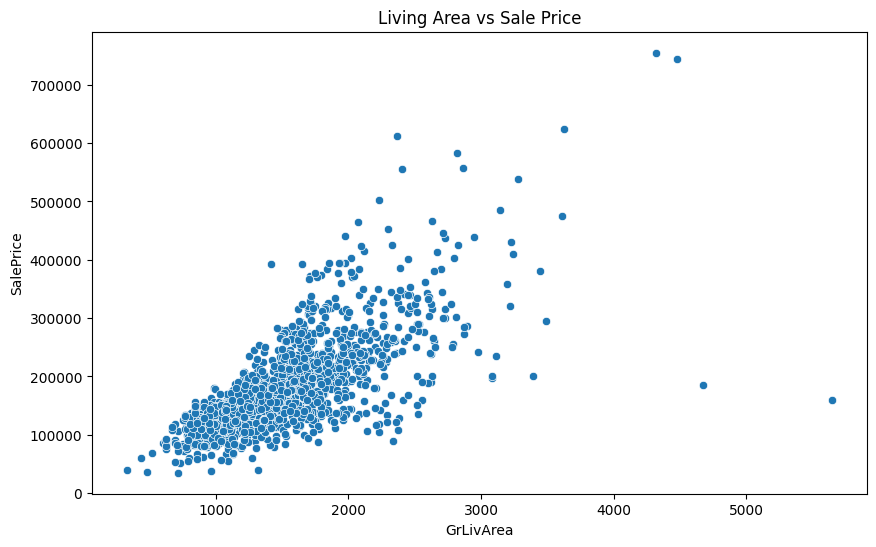

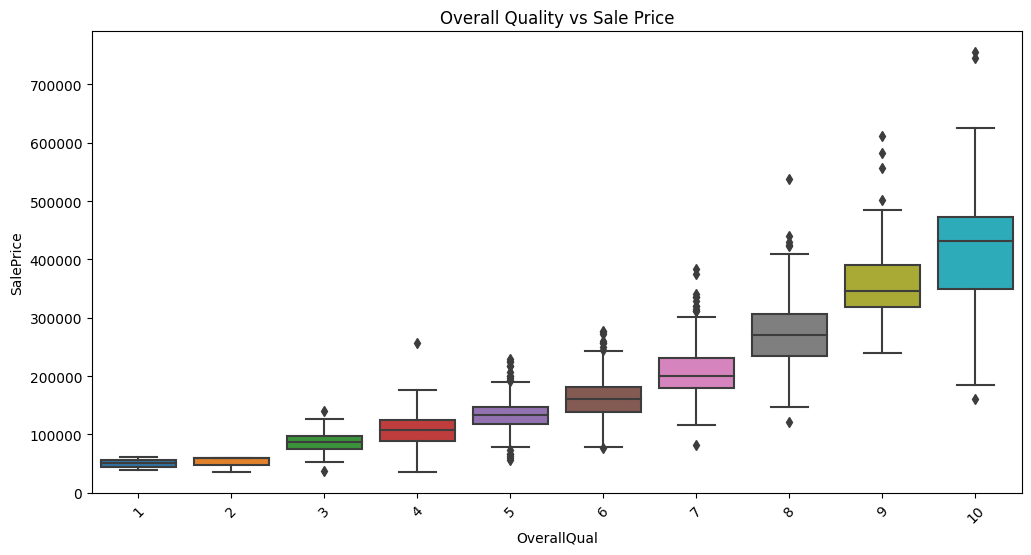

In [8]:
# Correlation heatmap for numeric features
plt.figure(figsize=(20, 15))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Scatter plot of two highly correlated features
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)
plt.title('Living Area vs Sale Price')
plt.show()

# Box plot of a categorical feature vs the target
plt.figure(figsize=(12, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=df)
plt.title('Overall Quality vs Sale Price')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Create a new feature: Total Square Footage
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

# Create a new feature: House Age
df['HouseAge'] = df['YrSold'] - df['YearBuilt']

# Create a new feature: Is Renovated
df['IsRenovated'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)

# Bin a continuous feature
df['AgeBin'] = pd.cut(df['HouseAge'], bins=[0, 10, 20, 30, 40, 50, 100], labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51+'])

# Log transform the target variable
df['LogSalePrice'] = np.log(df['SalePrice'])

# Interaction terms
df['Quality_Area'] = df['OverallQual'] * df['GrLivArea']

Top 10 features based on mutual information:
Quality_Area    0.744246
TotalSF         0.685711
OverallQual     0.560636
GrLivArea       0.458808
YearBuilt       0.362632
TotalBsmtSF     0.360759
GarageArea      0.359246
GarageCars      0.357286
HouseAge        0.334662
1stFlrSF        0.299574
Name: MI Scores, dtype: float64


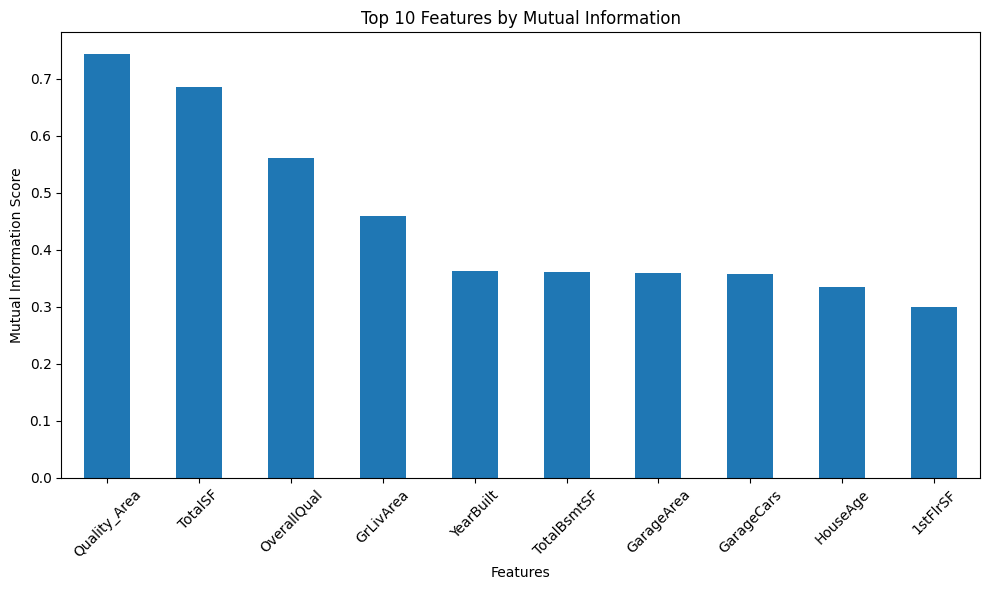

In [10]:
from sklearn.feature_selection import mutual_info_regression

# Select top 10 features based on mutual information with the target
def mutual_info_top_k(X, y, k=10):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores.head(k)

# Assuming 'SalePrice' is the target
X = df.drop(['SalePrice', 'LogSalePrice'], axis=1)
y = df['LogSalePrice']

# Select only numeric columns for this example
X_numeric = X.select_dtypes(include=['int64', 'float64'])

top_features = mutual_info_top_k(X_numeric, y)
print("Top 10 features based on mutual information:")
print(top_features)

# Visualize feature importance
plt.figure(figsize=(10, 6))
top_features.plot(kind='bar')
plt.title('Top 10 Features by Mutual Information')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()